In [111]:
!pip install -q snscrape 

In [3]:
import os 
import pandas as pd 
from os import listdir
from datetime import date, datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
%matplotlib inline
from textblob import TextBlob 
pd.set_option('display.max_colwidth', 100)

In [4]:
def date_range(start, end):
    delta = end - start  # as timedelta
    days = [start + timedelta(days=i) for i in range(delta.days + 1)]
    return_days = [day.date() for day in days]
    return return_days

start_date = datetime(2022, 3, 12)
end_date = datetime(2022, 4, 24)
    
date_range_for_data = date_range(start_date, end_date)


def create_tuples(date_range_list): 
    return_list = []
    
    # example [(2021-10-31, 2021-11-1), (2021-11-1, 2021-11-2)]
    for i in range(len(date_range_list)): 
        if not(date_range_list[i] == date_range_list[len(date_range_list)-1]):
            return_list.append((date_range_list[i], date_range_list[i+1]))

    return return_list

date_range_tuple = create_tuples(date_range_for_data)

In [5]:
# Get tweets function with 
# inputs (max_results, search_term, from_date, end_date)
# For us the from and end date will be the same 
# it will output a csv in the current directory with date as the start of the file
# and the search term (query at the start as well) 
def get_tweets(tweet_count, text_query, since_date, until_date):
    # Using OS library to call CLI commands in Python
    os.system('snscrape --jsonl --max-results {} --since {} twitter-search "{} until:{}"> text-query-tweets.json'.format( tweet_count, since_date, text_query, until_date))

    # Reads the json generated from the CLI command above and creates a pandas dataframe
    tweets_df = pd.read_json('text-query-tweets.json', lines=True)
    tweets_df.to_csv(f'{since_date}_{text_query}_tweets.csv', sep=',', index=False)

# Do not run this anymore

In [ ]:
tweet_count = 1000
text_query = "russia ukraine oil"

for date in date_range_tuple:
    get_tweets(tweet_count, text_query, date[0], date[1])

# Data Preprocessing 

#### Run this before you proceed with cleaning up and filtering the data 

#### final_dict - Is this dictionary that contains all the data according to dates as the key 

In [6]:
current_path = os.getcwd()

path_tweets = f'{current_path}/russia_ukraine_tweet/'

files = listdir(path_tweets)

#read files which end with csv 
# put them in a list 
#Input: all files in the directory list of files 
#Output: filter only the files 
def filter_csv(files):
    
    return_list = []
    
    for f in files: 
        if f.endswith('csv'):
            return_list.append(f)
    
    return return_list 

# Tested - Works well
files_list = filter_csv(files)
            
    
# write another function which makes a dictionary from a list of csv files 
# Prerequisite for the dictionary - filenames need to begin with dates 
# Key: Date Value: CSV 
# Input list of csv files
# Output : Dictionary - date and its constituent df 
def create_data_dictionary(files_list): 
    return_dict = {}
    files_with_no_data = [] 
    current_path = os.getcwd()
    data_path = f'{current_path}/russia_ukraine_tweet'
    for f in files_list:
        try:
            value = pd.read_csv(f'{data_path}/{f}')
            key = f[0:10]
            return_dict[key] = value
        except:
            files_with_no_data.append(f)
            continue 
            
    # to check if there are any files which are empty 
    # there is another way to filter and add it in this function itself but I have broken down 
    # for easier understanding. 
    return ((return_dict, files_with_no_data))

In [7]:
final_dict, files_with_no_data = create_data_dictionary(files_list)

# without days with no data 
final_days_of_data = len(final_dict.keys())

# input : dictionary , list of files 
# out : dictionary updated with file names but value is a string - 'no data'
def insert_null_val(dict_, files): 
    for i in files: 
        dict_[i[0:10]] = 'no value'
    
    return dict_

#with days with no data 
final_dict = insert_null_val(final_dict, files_with_no_data)

## Cleaning up each dataframe individually  - Name of Dictionary final_dict

In [9]:
# TODO: 
# Take a sample 
# Filter the data 
# Create functions and test on sample df shown below
# source = [twitter for android, twitter for ios, twitter web app, news sources] 
# language = en (english tweets only)
# clean up tweets 

# Sample data
# sample_df = final_dict['2022-03-14']

# filter dataframe using 'language' column
def filter_lang(dataframe):
    dataframe = dataframe.loc[dataframe['lang'] == 'en']
    return dataframe

# filter dataframe using 'sourceLabel' column
def filter_source(dataframe):
    dataframe.loc[dataframe['sourceLabel'].str.contains('iPad|iPhone|Mac'), 'sourceLabel'] = 'twitter for ios'
    dataframe.loc[dataframe['sourceLabel'].str.contains('Android'), 'sourceLabel'] = 'twitter for android'
    dataframe.loc[dataframe['sourceLabel'].str.contains('News'), 'sourceLabel'] = 'news sources'
    return dataframe

# apply both filter_lang and filter_source functions to a dataframe
def filtered_data(dataframe):
    dataframe = filter_lang(dataframe)
    dataframe = filter_source(dataframe)
    return dataframe

# sample_df = filtered_data(sample_df)

In [10]:
# check whether a string is English
# True - String is English, False - String contains non-english characters (excluding emojis and special characters)
def isEnglish(value):
    return value.isascii()

# Extract rows with English content from a dataframe
# may use this function instead of filter_lang()
def filter_english(dataframe):
    for i, r in dataframe.iterrows():
        dataframe.loc[i, ['isEnglish']] = isEnglish(r['content'])
    
    dataframe = dataframe.loc[dataframe['isEnglish'] == True]
    return dataframe

### Removing Stop Words and Punctuation  

In [11]:
#https://aronakhmad.medium.com/twitter-data-cleaning-using-python-db1ec2f28f08
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud,STOPWORDS 
from nltk.stem.porter import PorterStemmer
nltk.download([
     "names",
     "stopwords",
     "state_union",
     "twitter_samples",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt", ])



n_words = set(stopwords.words('english')) # stop words list 
porter = PorterStemmer()


stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

[nltk_data] Downloading package names to /Users/bhuwan/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bhuwan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     /Users/bhuwan/nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/bhuwan/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/bhuwan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bhuwan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bhuwan/nltk_data...
[nltk_data]   Package

In [207]:
sample_df['content'] = sample_df['content'].apply(lambda x: clean(x))

In [94]:
from nltk.sentiment import SentimentIntensityAnalyzer

def find_overall(compound_value): 
    if compound_value > -0.04: 
        return 'POS'
    elif compound_value < -0.17: 
        return 'NEG'
    else: 
        return 'NEU'

def find_sentiment(dataframe):
    list_of_polarity= []
    sia = SentimentIntensityAnalyzer()
    list_rows_skipped = []
    counter = 0 
    

    for i in dataframe['content']:
        try:
            compound = sia.polarity_scores(i)['compound']
            list_of_polarity.append((i, compound))
            counter += 1
        except:
            list_rows_skipped.append(i)
            counter += 1
    
    temp_df = pd.DataFrame(list_of_polarity, columns=['date', 'compound'])

    overall_sentiment = temp_df['compound'].mean()
    
    result = find_overall(overall_sentiment)
                                 
    return result
        


In [42]:
list_app = []
for i in final_dict.keys(): 
    if isinstance(final_dict[i],str): 
        print(i, final_dict[i])


2022-03-05 no value
2022-03-31 no value
2022-03-04 no value
2021-11-01 no value
2022-03-08 no value
2022-03-07 no value
2022-03-10 no value
2022-03-06 no value
2022-03-09 no value


In [ ]:
def final_dataframe(final_dict):
    final_dict_list = []
    
    for i in final_dict.keys():
        temp_df = final_dict[i]
        if not(isinstance(temp_df, str)) and ('content' in temp_df.columns) : 
            temp_df['content'] = temp_df['content'].apply(lambda x : clean(x))
            final_dict_list.append((i, find_sentiment(temp_df)))
        
    return_df = pd.DataFrame(final_dict_list, columns = ['Date', 'Sentiment'])
    return return_df
#     temp_df = final_dict[i]
#     temp_df['content'] = temp_df['content'].apply(lambda x : clean(text))

final_df = final_dataframe(final_dict)
    

In [93]:
final_df['Sentiment'].value_counts()

NEG    93
NEU    54
POS    19
Name: Sentiment, dtype: int64

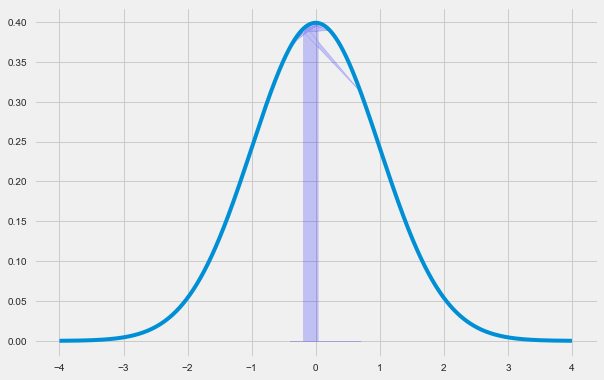

In [59]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#create range of x-values from -4 to 4 in increments of .001
x = np.arange(-4, 4, 0.001)

#create range of y-values that correspond to normal pdf with mean=0 and sd=1 
y = norm.pdf(x,0,1)

#define plot 
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x,y)

#specify the region of the bell curve to fill in 
x_fill = final_df['Sentiment']
y_fill = norm.pdf(x_fill,0,1)
ax.fill_between(x_fill,y_fill,0, alpha=0.2, color='blue')
#choose plot style and display the bell curve 
plt.style.use('fivethirtyeight')
plt.show()





## Testing 



In [191]:
def get_sentiment(tweets_df): 
    tweets = [] 
    try: 
        for tweet in tweets_df.iteritems():
            analysis = TextBlob(str(tweet))
            senti= analysis.sentiment.polarity
            # labeling the sentiment
            if senti < 0 :
                emotion = "NEG"
            elif senti > 0 :
                emotion= "POS"
            else:
                emotion= "NEU"
            # appending all data
            tweets.append((tweet, senti, emotion))
            sentiment_df = pd.DataFrame(tweets, columns=['tweet', 'senti', 'emotion'])
        return sentiment_df
    except tweepy.TweepyException as e: 
        print("Error : " + str(e))
        

# tweets_sentiment = get_sentiment(sample_df['content'])

In [192]:
# This function is supposed to help find the overall sentiment per day 
# Given the data for the day with sentiment 
# Find the overall sentiment ignoring the neutrality 

# Break this up into two or three functions 
def check_pos_neg(day_df_sentiment): 
    if day_df_sentiment.isin({'emotion': ['POS', 'NEG']}):
        return True 
    else:
        return False
    
def check_neg_neu(day_df_sentiment): 
    if day_df_sentiment.isn({'emotion': ['NEU', 'NEG']}):
        return True
    else: 
        return False

# one function to check if the negative or positive values exist in the emotion column
def overall_sentiment(day_df_sentiment):
    try:
        # if day_df_sentiment has 'POS' and 'NEG' as a value in its column of emotion 
        if check_emotion(day_df_sentiment):
            positive = day_df_sentiment['emotion'].value_counts()['POS']
            negative = day_df_sentiment['emotion'].value_counts()['NEG']
    
            overall = positive - negative 
    
            if overall > 0: 
                return 'POS'
            else: 
                return 'NEG'
        # check negative and neutral 
        elif check_neg_neu(day_df_sentiment):
            neutral = day_df_sentiment['emotion'].value_counts()['NEU']
            negative = day_df_sentiment['emotion'].value_counts()['NEG']
            
            overall = neutral - negative
            
            if overall > 0: 
                return 'NEU'
            else: 
                return 'NEG'
        else: 
            return 'NEU'
    except: 
        print("Error occurred")
            
        
        

### Final Combination of Dfs

In [195]:
# Each df from 
def df_clean_up_and_sentiment_dict(result_data_dict):
    #copy the given dict for copy of keys 
    sentiment_dict = result_data_dict
    final_list = []
    
    for key in result_data_dict.keys():
        # get the df from dict
        temp_df = result_data_dict[key]
        # clean the df and update the df in the dict
#         temp_df = filtered_data(temp_df)
        temp_df['content'] = temp_df['content'].apply(lambda x : clean(x))
        # Once cleaned get the sentiment df 
        temp_sentiment_df = get_sentiment(temp_df)
        # temp_sentiment
        final_list.append((sentiment_dict[key], overall_sentiment(temp_sentiment_df)))
        
    return final_list 


In [197]:
# list_emotion_per_day = df_clean_up_and_sentiment_dict(final_dict)

In [201]:
sample_df = final_dict['2022-03-20']

sample_df = sample_df['content'].apply(lamda x : clean(x))



0      As sanctions over Ukraine war mount, Russia turns to India to buy oil and arms - The Washington ...
1      @gr8shotkeith These oil companies are lying. \n\nAccording to what I heard they already have 9,0...
2      USD/CAD struggles to defend 1.2600 as Ukraine-Russia crisis favors oil buyers By @anilpanchal7 h...
3      The invasion of Ukraine has exposed the European vulnerability to the supply of Russian oil and ...
4                    @PPouyanne  #mariupol and you are still in Russia ? Shame on you!\n#Ukraine #Oil #Gas
                                                      ...                                                 
221    For global food market or hunger, there are few worse countries to be in conflict than Russia an...
222    @GOPChairwoman When Russia invaded Ukraine, crude oil was $99 a barrel. Today, it's fallen back ...
223    @conspiracyb0t No thanks.  It is an unfortunate set of circumstances in Ukraine.  It is not our ...
224                 @IAPonomarenko Uk